## Personalized Learning (Localized Learning?)

#### This notebook includes the following online models;
1. A single global model with all data
2. Multiple local models (starting from a single global model)
   1. that are updated with new data
   2. that exchanges data in clusters
   3. that exchanges parameters in clusters

  
#### The dataset that is used for this project is [CIFAR-100 dataset][1]
* Has 100 classes containing 600 images each

#### New data are fed by the following rules;
1. Distributed, according to superclasses
  * Clusters will only be updated with data that belongs to a specific superclass
  * We update the NN by
    1. Changing all parameters of the NN
    2. Only changing the last few layers, as in many MTL models
2. Randomly (why?)

#### We expect to find an answer to the following research questions with this project;
1. If models are updated with data (or parameters) that are shared within a cluster, can the model perform good enough with the labels that count?
  * For example, the performance of the cluster that are updated with "Vehicles" superclass is only assessed with the labels that corresponds to the superclass.
  
[1]: https://www.cs.toronto.edu/~kriz/cifar.html

#### Questions

Retraining: how does it work <br>
How do we compare these models?


### Implementation with Custom Neural Network and EMNIST dataset

In [96]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [97]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [98]:
import matplotlib

In [99]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [100]:
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [101]:
tf.__version__

'1.15.0'

In [102]:
# Hyperparameters
batch_size = 50
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

#### Load MNIST dataset

In [103]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [104]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [105]:
x_train.shape

(60000, 28, 28, 1)

In [106]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [107]:
global_dataset_size = 20000
local_dataset_size = 40000

In [108]:
X_global = x_train[-global_dataset_size:]
Y_global = y_train[-global_dataset_size:]
X_local = x_train[:-global_dataset_size]
Y_local = y_train[:-global_dataset_size]

In [109]:
len(np.unique(y_train))

10

In [110]:
import utils

In [111]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/seth/projects/fed-learn-experiment/utils.py'>

In [112]:
X_local_list, Y_local_list = utils.split_training_set(2000, 20, X_local, Y_local)

In [113]:
# convert class vectors to binary class matrices
num_classes = 10
Y_global = keras.utils.to_categorical(Y_global, num_classes)

In [114]:
y_test = keras.utils.to_categorical(y_test, num_classes)

In [115]:
x_test.shape

(10000, 28, 28, 1)

### Define models and compile & fit function

In [116]:
def custom_model():
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [117]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [118]:
def compile_model_lr(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [119]:
def fit_model_global(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(X_global, Y_global,
                      batch_size=100,
                      epochs=40,
                      shuffle=True, callbacks=[tensorboard_callback])

In [120]:
def fit_model_with_datasets(model, epochs, x_train, y_train):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True, validation_split=0.1, verbose=0)

In [121]:
model1 = custom_model()
compile_model(model1)
fit_model_with_datasets(model1, 1, X_global, Y_global)

Training date and time : 
2020-04-22 14:45:20


In [122]:
model_list = list()
for _ in range(40):
    model_list.append(tf.keras.models.clone_model(model1)) 
    model_list[_].set_weights(model1.get_weights())

In [123]:
# sort models according to similarity. We arbitrarily take the model1 as a "standard"
standard_model = tf.keras.models.clone_model(model1)
standard_model.set_weights(model_list[0].get_weights())

In [124]:
import semantic_drift

In [125]:
importlib.reload(semantic_drift)

<module 'semantic_drift' from '/home/seth/projects/fed-learn-experiment/semantic_drift.py'>

### Conduct transfer learning in local models using different datasets & epochs


In [126]:
for i in range(len(model_list)):
    compile_model(model_list[i])
    fit_model_with_datasets(model_list[i], (i+1)*5, X_local_list[0], Y_local_list[0])

Training date and time : 
2020-04-22 14:45:28
Training date and time : 
2020-04-22 14:45:28
Training date and time : 
2020-04-22 14:45:29
Training date and time : 
2020-04-22 14:45:30
Training date and time : 
2020-04-22 14:45:32
Training date and time : 
2020-04-22 14:45:34
Training date and time : 
2020-04-22 14:45:36
Training date and time : 
2020-04-22 14:45:38
Training date and time : 
2020-04-22 14:45:41
Training date and time : 
2020-04-22 14:45:44
Training date and time : 
2020-04-22 14:45:47
Training date and time : 
2020-04-22 14:45:51
Training date and time : 
2020-04-22 14:45:55
Training date and time : 
2020-04-22 14:45:59
Training date and time : 
2020-04-22 14:46:03
Training date and time : 
2020-04-22 14:46:08
Training date and time : 
2020-04-22 14:46:13
Training date and time : 
2020-04-22 14:46:19
Training date and time : 
2020-04-22 14:46:24
Training date and time : 
2020-04-22 14:46:30
Training date and time : 
2020-04-22 14:46:37
Training date and time : 
2020-04-

### Let's see how these models are different from each other, compared to the base model(before training)


In [127]:
dists = [semantic_drift.l2_distance(standard_model, m) for m in model_list]
print(dists)

[0.52366126, 1.0429718, 1.4534358, 1.7587999, 1.9925766, 2.1841142, 2.3430238, 2.481855, 2.6058857, 2.7169566, 2.8187797, 2.9130058, 3.0002615, 3.081361, 3.1586182, 3.229794, 3.2976875, 3.3624294, 3.423769, 3.482358, 3.538053, 3.5921955, 3.6435492, 3.6935084, 3.7417965, 3.7885647, 3.8344615, 3.8787081, 3.92122, 3.9625483, 4.002632, 4.042253, 4.0799174, 4.1178837, 4.154286, 4.1901, 4.224825, 4.258705, 4.2924767, 4.325076]


In [128]:
np.arange(5, (len(dists)+2)*5, 5)

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205])

### The l2-distance increases in respect to epochs

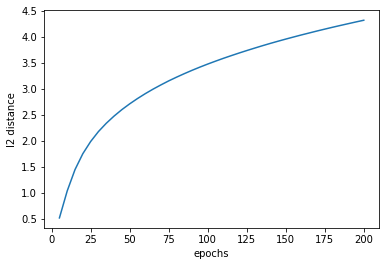

In [129]:
import matplotlib.pyplot as plt
plt.plot(np.arange(5, (len(dists)+1)*5, 5), np.array(dists))
plt.ylabel("l2 distance")
plt.xlabel("epochs")
plt.show()

### Change THETA_AS_VARIABLE to true to get a 3D graph

In [130]:
THETA_AS_VARIABLE = False

In [131]:
if not THETA_AS_VARIABLE:
    theta_list = [0, 0.6, 1]
    agg_weights_list_per_pi = list()
    dist_list = list()

    for model in model_list:
        weights = [model1.get_weights(), model.get_weights()]
        agg_weights_list = list()
        for theta in theta_list:
            agg_weights = list()
            for weights_list_tuple in zip(*weights):
                agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
            agg_weights_list.append(agg_weights)
        dist_list.append(semantic_drift.l2_distance(model1, model))
        agg_weights_list_per_pi.append(agg_weights_list)

In [132]:
if THETA_AS_VARIABLE:
    theta_list = list(np.arange(0, 1.05, 0.05))
    agg_weights_list_per_pi = list()    # \pi for perturbations
    dist_list = list()
    for model in model_list:
        weights = [model1.get_weights(), model.get_weights()]
        agg_weights_list = list()
        for theta in theta_list:
            agg_weights = list()
            for weights_list_tuple in zip(*weights):
                agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
            agg_weights_list.append(agg_weights)
        dist_list.append(semantic_drift.l2_distance(model1, model))
        agg_weights_list_per_pi.append(agg_weights_list)

In [133]:
len(dist_list)

40

In [134]:
if not (np.diff(dist_list)>0).all():
    print("The dist list does not monotonically increase!")

In [135]:
if not THETA_AS_VARIABLE:
    B = np.zeros(len(agg_weights_list_per_pi))

    i = 0
    for agg_weights_list in agg_weights_list_per_pi:

        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights_list[1])
        compile_model(aggr_model)
        score = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)
        
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights_list[0])
        compile_model(aggr_model)
        comp_score1 = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)
        
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights_list[2])
        compile_model(aggr_model)
        comp_score2 = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)
        
        B[i] = score[0] - min(comp_score1[0], comp_score2[0])
        K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
        i += 1
        if i % 10 == 0:
            print("{}th iteration".format(i))

10th iteration
20th iteration
30th iteration
40th iteration


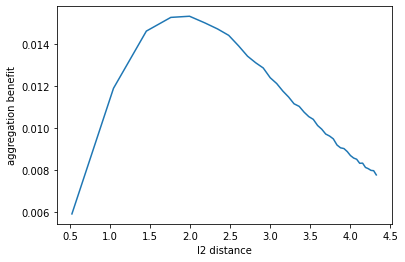

In [136]:
epoch_list = np.arange(5, (len(dist_list)+1)*5, 5)
if not THETA_AS_VARIABLE:
    plt.plot(np.array(dist_list), np.array(B))
    plt.ylabel("aggregation benefit")
    plt.xlabel("l2 distance")
    plt.show()

In [93]:
if THETA_AS_VARIABLE:
    X, Y = np.meshgrid(np.array(theta_list), np.array(dist_list))
    Z = np.zeros(X.shape)
    i = 0
    for agg_weights_list in agg_weights_list_per_pi:
        j = 0
        for agg_weights in agg_weights_list:
            aggr_model = keras.models.clone_model(model1)
            aggr_model.set_weights(agg_weights)
            compile_model(aggr_model)
            score = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)
            Z[i][j] = score[0]
            j += 1
            K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
        i += 1
        print("{}th iteration".format(i))

1th iteration
2th iteration
3th iteration
4th iteration
5th iteration
6th iteration
7th iteration
8th iteration
9th iteration
10th iteration
11th iteration
12th iteration
13th iteration
14th iteration
15th iteration
16th iteration
17th iteration
18th iteration
19th iteration
20th iteration


In [94]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

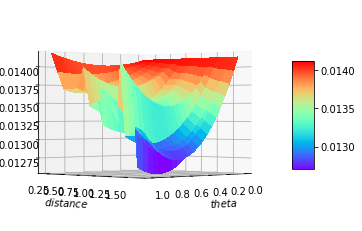

In [98]:
if THETA_AS_VARIABLE:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.rainbow,
                           linewidth=0, antialiased=False)
    ax.set_xlabel('$theta$')
    ax.set_ylabel('$distance$')
    ax.set_zlabel('$loss$')
    # Customize the z axis.
    # ax.set_xlim(0.051, 0.054)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.view_init(0, 45)
    # ax.view_init(0, 0)
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.savefig('fig1.png')
    plt.show()